# AutoEncoder

- 入力と出力が同じになるようにニューラルネットを学習させるもの
- 入力をラベルとして扱って教師なしと教師ありの中間に位置するような存在
- 出力ではなく特徴を抽出することを重視する

<img src="./img/autoencoder.png">

これまで次元削減や表現学習などの用途で使われてきた→表現学習目的で使われることは少なくなっている

→生成モデル(generative model)として注目されている．

## Undercomplete Autoencoder

- エンコードされたデータ(コード)の次元数が入力の次元数よりも少ないもの

Undercomplete Autoencoderで活性化関数が恒等写像(活性化関数なし)，損失関数が二乗誤差

→主成分分析に相当

→コードの次元数が入力の次元数よりも大きいもの：Overcomplete Autoencoder

    損失関数を変更し，制約を加えたり，ノイズを加えることで意味のある特徴を抽出できるようにする
    
    →Regularized Autoencoder

### 実装

In [13]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

def autoencoder_train(optimizer='adadelta', loss='binary_crossentropy'):
    encoding_dim = 32 # 中間層は32次元
    input_img = Input(shape=(784,)) # 入力と出力は784次元
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)  # 入力と出力は784次元
    autoencoder = Model(input=input_img, output=decoded)

    # オプティマイザにはAdadelta、損失関数にはバイナリエントロピー
    autoencoder.compile(optimizer=optimizer, loss=loss)

    (x_train, _), (x_test, _) = mnist.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

    autoencoder.fit(x_train, x_train,
                    nb_epoch=50,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test))
    return autoencoder

In [13]:
optimizer='adagrad'
autoencoder = autoencoder_train(optimizer=optimizer)
autoencoder.save_weights('./model/autoencoder_{}_binary_crossentropy.h5'.format(optimizer))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 0s - loss: 0.2081 - val_loss: 0.1682

### 入力と出力の可視化

original


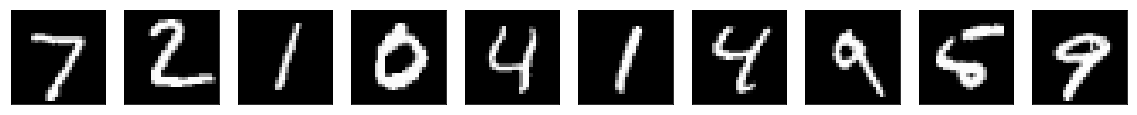

adam


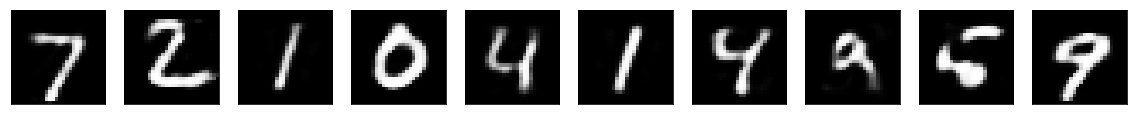

adagrad


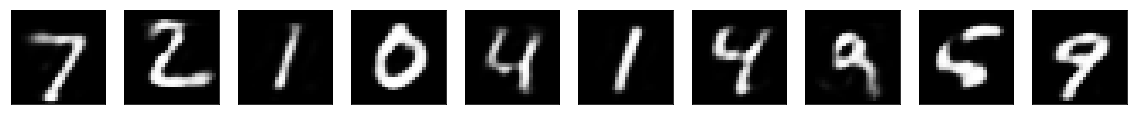

adadelta


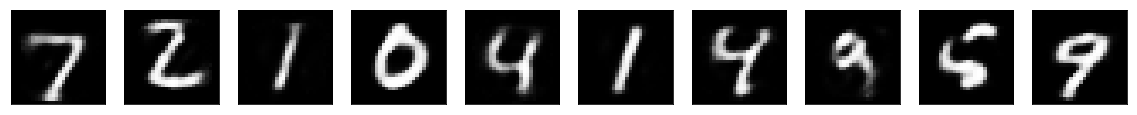

sgd


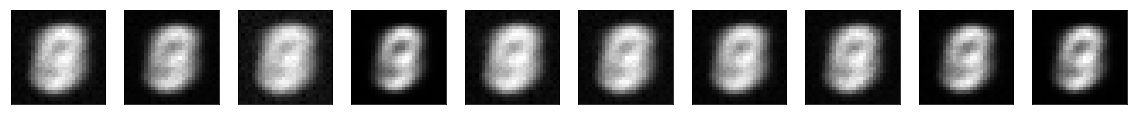

rmsprop


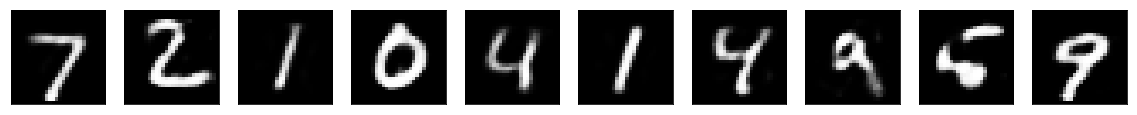

In [39]:
import matplotlib.pyplot as plt

plt.close('all')
encoding_dim = 32 # 中間層は32次元
input_img = Input(shape=(784,)) # 入力と出力は784次元
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)  # 入力と出力は784次元
autoencoder = Model(input=input_img, output=decoded)

# 何個表示するか
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # オリジナル画像を表示
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
print('original')
plt.show()
 
# テスト画像を変換
for optimizer in ['adam', 'adagrad', 'adadelta', 'sgd', 'rmsprop']:
    autoencoder = Model(input=input_img, output=decoded)
    autoencoder.load_weights('./model/autoencoder_{}_binary_crossentropy.h5'.format(optimizer))
    decoded_imgs = autoencoder.predict(x_test)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # 変換された画像を表示
        ax = plt.subplot(1, n, i+1)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    print(optimizer)
    plt.show()

## Sparse Autoencoder

- デコードに対して求める損失関数にペナルティを与える

→入力よりもコードの次元数が大きいOvercomplete Autoencoderでもペナルティで特徴を抽出できる

入力を $x$ ，エンコードされたもの $h = f(x)$ とすると，

$$
L(x, g(f(x))) + \Omega(h)\\
損失関数 + ペナルティ
$$


### 実装

In [52]:
from keras import regularizers

encoding_dim = 32 # 中間層は32次元
input_img = Input(shape=(784,)) # 入力と出力は784次元

# activity regularizerを加える
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.activity_l1(1e-4))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded) # 入力と出力は784次元
sparse_autoencoder = Model(input=input_img, output=decoded)

sparse_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
sparse_autoencoder.fit(x_train, x_train,
                nb_epoch=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s - loss: 0.6544 - val_loss: 0.6154

Undercomplete Autoencoderとのコードの変更点

- activity_regularizerにregularizers.activity_l1を設定

In [53]:
sparse_autoencoder.save_weights('./model/sparse_autoencoder_adam_binary_crossentropy.h5')

### 入力と出力の可視化

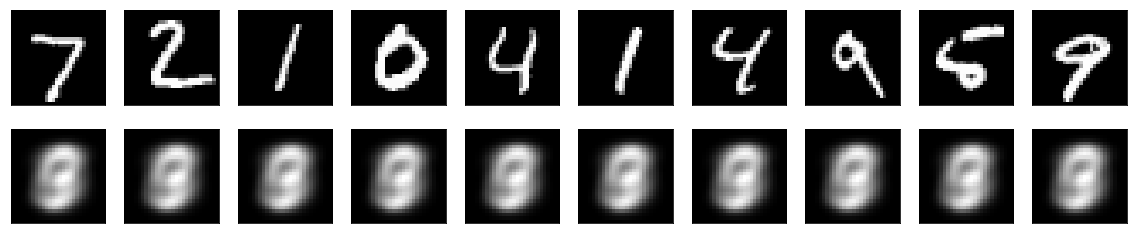

In [55]:
sparse_autoencoder.load_weights('./model/sparse_autoencoder_adam_binary_crossentropy.h5')
decoded_imgs = sparse_autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Deep Autoencoder

ここまでのAutoencoderは順伝搬型NN

→層を増やし，エンコーダの表現力を増す

### 実装

In [56]:
encoding_dim = 32
input_img = Input(shape=(784,))

encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

deep_autoencoder = Model(input=input_img, output=decoded)
deep_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
deep_autoencoder.fit(x_train, x_train,
                nb_epoch=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s - loss: 0.2390 - val_loss: 0.1626

In [57]:
deep_autoencoder.save_weights('./model/deep_autoencoder_adam_binary_crossentropy.h5')

### 入力と出力の可視化

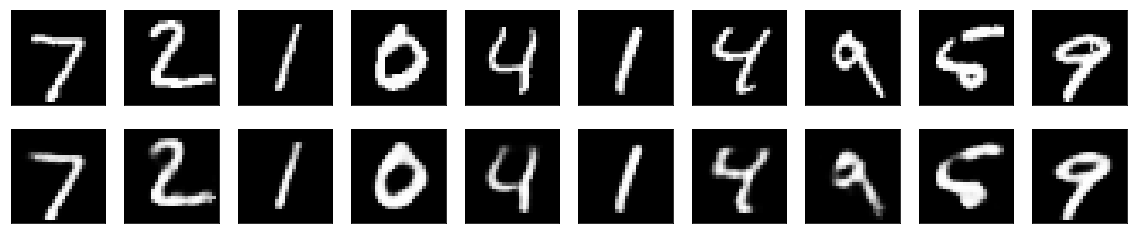

In [58]:
deep_autoencoder.load_weights('./model/deep_autoencoder_adam_binary_crossentropy.h5')
decoded_imgs = deep_autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Convolutional Autoencoder

画像認識においてMLP(Multilayer Perceptron)よりも成果を上げているCNNを使う



### 実装

In [2]:
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(1, 28, 28))

# same→zero padding
x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)

x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, 3, 3, activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)

In [4]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 28, 28)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 28, 28)    160         input_1[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 14, 14)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 8, 14, 14)     1160        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

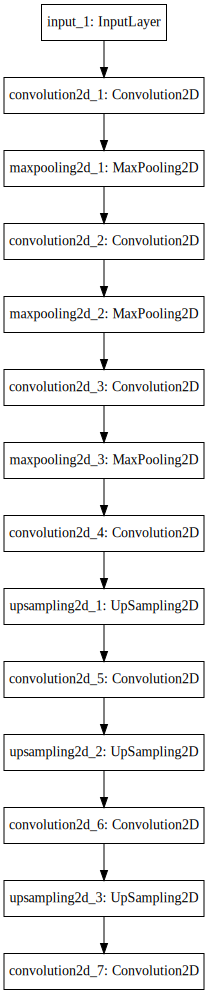

In [5]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

cnn_autoencoder = Model(input_img, decoded)
cnn_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# cnn_autoencoder.summary()

SVG(model_to_dot(cnn_autoencoder).create(prog='dot', format='svg'))

In [6]:
cnn_autoencoder.fit(x_train, x_train,
                       nb_epoch=50,
                       batch_size=128,
                       shuffle=True,
                       validation_data=(x_test, x_test)
                   )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 13s - loss: 0.2166 - val_loss: 0.1509

In [7]:
cnn_autoencoder.save_weights('./model/cnn_autoencoder_adam_binary_crossentropy.h5')

### 入力と出力の可視化

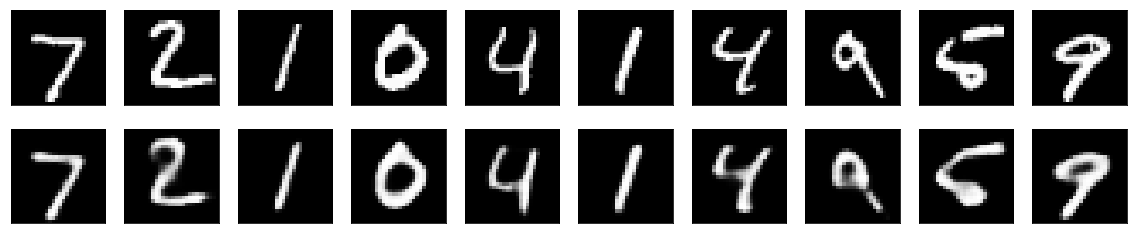

In [14]:
cnn_autoencoder.load_weights('./model/cnn_autoencoder_adam_binary_crossentropy.h5')
decoded_imgs = cnn_autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### エンコード結果の可視化

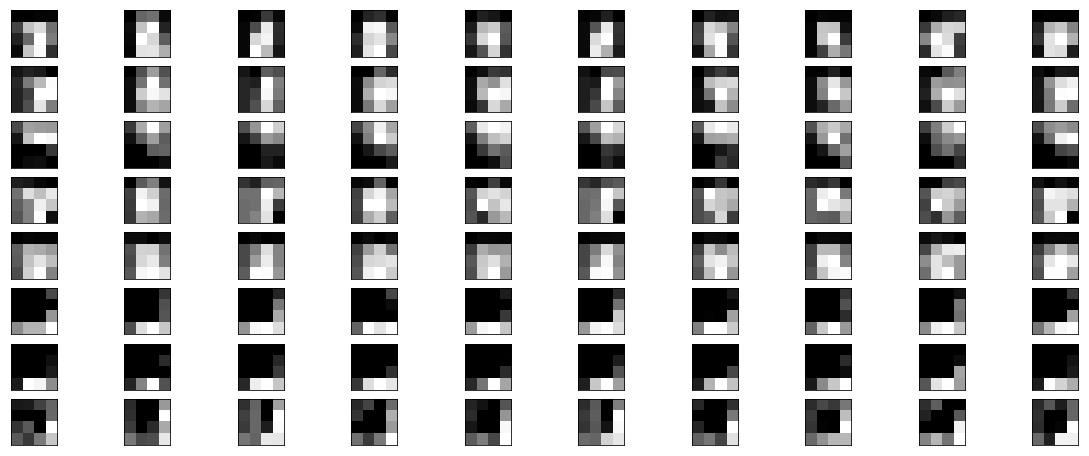

In [20]:
n = 10
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test[:n])

plt.figure(figsize=(20, 8))
for i in range(n):
    for j in range(8):
        ax = plt.subplot(8, n, j*n + i+1)
        plt.imshow(encoded_imgs[i][j], interpolation='none')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

## DAE (Denoising Autoencoder)

$\tilde{x}$ を入力にノイズを加えたものとする

$$
L(x, g(f(\tilde{x})))
$$

ノイズが加わった入力からオリジナルの入力を復元しないといけない

→単にコピーを作るだけでなく，ノイズを除去する

→いい特徴を学習できるようになると考えられている

### ノイズ付与

In [22]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))

noise_factor = 0.5
# 平均0、標準偏差1の正規分布に基づいてノイズを乗せる
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0., scale=1., size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0., scale=1., size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

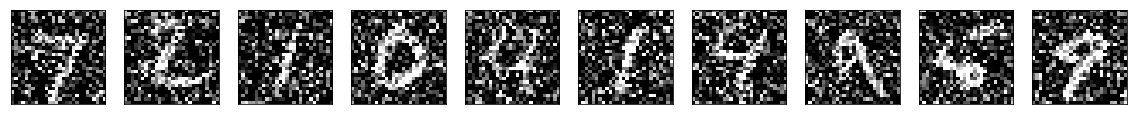

In [23]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 実装

In [24]:
# same→zero padding
x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)

x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, 3, 3, activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)

dae = Model(input_img, decoded)
dae.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
dae.fit(x_train_noisy, x_train,
                       nb_epoch=50,
                       batch_size=128,
                       shuffle=True,
                       validation_data=(x_test_noisy, x_test)
                   )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 12s - loss: 0.2671 - val_loss: 0.1951

In [27]:
dae.save_weights('./model/dae_autoencoder_adam_binary_crossentropy.h5')

### 入力層と出力層の可視化

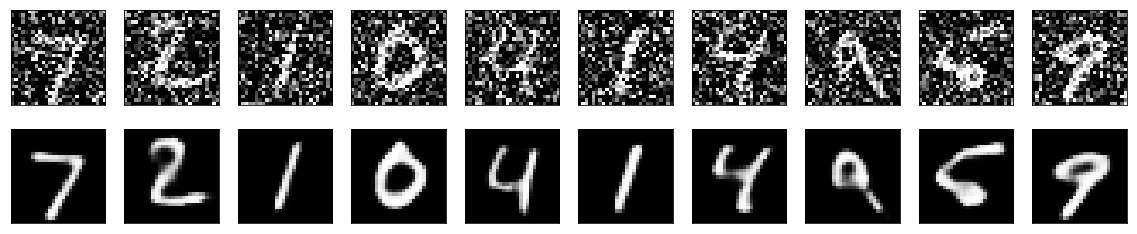

In [29]:
dae.load_weights('./model/dae_autoencoder_adam_binary_crossentropy.h5')
decoded_imgs = cnn_autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()